# 💡 Project3 : 모두의 주차장 데이터를 활용하여 수요 예측하기

## ⚡ SUMMARY

> **분석 목표** : 모두의 주차장 이용자별 향후 이용 건수 예측하기(향후 1개월 이용 예측)

> **분석 자료** :   
1 2020.01.01 ~ 2020.12-31 이용 데이터  
2020.01.01 - 2020.09.30 : Training Data  
2020.10.01 - 2020.12.31 : Test Data  
2 외부 정보: 서울시 지점별 교통량 데이터 기온, 강수량, 풍속 등 기상데이터 

> **결과 측정** : MSE, MAE
    
> **분석 결론** : 

## ⚡ 목차

>### 1. 프로젝트 개요
>### 2. EDA 및 분석
>### 3. 분석모형과 오차 계산

## ⚡ 1. 프로젝트 개요

모두의 주차장 이용자별 향후 이용 건수 예측하기(향후 1개월 이용 예측)

<U>기본 데이터:</U> 2020.01.01 ~ 2020.12-31 이용 데이터  
2020.01.01 - 2020.09.30 : Training Data  
2020.10.01 - 2020.12.31 : Test Data   

## ⚡ 2. EDA 및 분석

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic' # Windows용
%matplotlib inline

In [2]:
df = pd.read_csv('./data/실전db.csv')

• 유저 가입 정보   
USER_ID : id  
JOIN_DATE : 가입일   

• 소비 행동 정보  
D_TYPE : ?   
STORE_ID : 점포 ID  
GOODS_TYPE : 상품ID  
DATE : 결제일  
COUNT : 결제건수  
AD1 : 점포 주소

In [3]:
df.shape

(879271, 8)

In [4]:
df.head()

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   USER_ID     879271 non-null  int64 
 1   JOIN_DATE   879271 non-null  object
 2   D_TYPE      879271 non-null  object
 3   STORE_ID    879271 non-null  int64 
 4   GOODS_TYPE  879271 non-null  object
 5   DATE        879271 non-null  object
 6   COUNT       879271 non-null  int64 
 7   AD1         879271 non-null  object
dtypes: int64(3), object(5)
memory usage: 53.7+ MB


* 날짜 데이터 형변환 (object > datetime64)

In [6]:
df.JOIN_DATE = pd.to_datetime(df.JOIN_DATE)
df.DATE = pd.to_datetime(df.DATE)

In [7]:
df.dtypes

USER_ID                int64
JOIN_DATE     datetime64[ns]
D_TYPE                object
STORE_ID               int64
GOODS_TYPE            object
DATE          datetime64[ns]
COUNT                  int64
AD1                   object
dtype: object

In [8]:
df.describe()

,USER_ID,STORE_ID,COUNT
count,8.792710e+05,879271.000000,879271.000000
mean,1.206566e+06,149599.960642,1.029079
std,4.206529e+05,68898.035318,0.512428
min,2.240000e+02,4.000000,1.000000
25%,9.005760e+05,92437.000000,1.000000
50%,1.321440e+06,173059.000000,1.000000
75%,1.542416e+06,220661.000000,1.000000
max,1.830598e+06,231465.000000,61.000000


### 각각의 컬럼 살펴보기   
### * USER_ID

* 중복 제거한 ID는 총 165425개 

In [9]:
len(df['USER_ID'].unique())

165425

* ID별 데이터 갯수(row count)

In [10]:
df['USER_ID'].value_counts()

999665     366
591610     244
1355841    235
1365069    222
1224426    222
          ... 
650196       1
1649612      1
1643467      1
1751998      1
1060858      1
Name: USER_ID, Length: 165425, dtype: int64

In [11]:
df_top20 = pd.DataFrame(df['USER_ID'].value_counts())
df_top20

,USER_ID
999665,366
591610,244
1355841,235
1365069,222
1224426,222
...,...
650196,1
1649612,1
1643467,1
1751998,1


* ID 999665의 경우 366개로 데이터가 가장 많다. 

In [12]:
df[df['USER_ID'] == 999665]

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
372,999665,2018-12-16,CC,82399,A,2020-01-01,6,JRR
1527,999665,2018-12-16,CC,104988,A,2020-01-02,11,GN
3121,999665,2018-12-16,CC,181832,A,2020-01-03,7,SC
5034,999665,2018-12-16,CC,109223,A,2020-01-04,28,MP
6919,999665,2018-12-16,CC,104916,A,2020-01-05,14,GN
...,...,...,...,...,...,...,...,...
867260,999665,2018-12-16,CC,2428,A,2020-12-27,17,CY
868847,999665,2018-12-16,CC,109267,A,2020-12-28,24,J
871562,999665,2018-12-16,CC,90193,C,2020-12-29,23,GW
874317,999665,2018-12-16,CC,220797,D,2020-12-30,40,GS


ID 999665의 경우 28개 지역에서 모두의 주차장을 사용했다. 

In [13]:
len(df[df['USER_ID'] == 999665].AD1.unique())

28

ID 999665의 경우 사용한 주차장 갯수는 140개(중복제거)

In [14]:
len(df[df['USER_ID'] == 999665].STORE_ID.unique())

140

In [15]:
df['USER_ID'].value_counts().nlargest(20)

999665     366
591610     244
1355841    235
1365069    222
1224426    222
1407916    222
1144500    213
1284291    210
909315     209
1201981    207
1504815    207
612237     201
1303371    199
640247     199
1532535    198
603013     198
571472     198
812843     197
1506306    197
1419336    194
Name: USER_ID, dtype: int64

In [16]:
df[df.USER_ID.isin([999665,591610,1355841,1365069,1224426,1407916,1144500,1284291,909315,
1201981,1504815,612237,1303371,640247,1532535,603013,571472,812843,1506306,1419336])].groupby(['USER_ID']).D_TYPE.min()

USER_ID
571472     AA
591610     AA
603013     AA
612237     AA
640247     BB
812843     AA
909315     BB
999665     CC
1144500    AA
1201981    BB
1224426    BB
1284291    AA
1303371    AA
1355841    AA
1365069    AA
1407916    AA
1419336    BB
1504815    AA
1506306    AA
1532535    BB
Name: D_TYPE, dtype: object

In [17]:
df.groupby('USER_ID').sum().reset_index().sort_values('COUNT', ascending = False)

,USER_ID,STORE_ID,COUNT
44115,999665,44476875,7919
100781,1514190,18343755,284
16448,591610,27630786,245
90227,1467323,12808488,239
76230,1355841,25745895,235
...,...,...,...
45671,1023974,203627,1
110166,1551355,204949,1
45674,1024027,182320,1
45676,1024047,181833,1


In [18]:
df.groupby('USER_ID')['COUNT'].sum().reset_index().sort_values('COUNT', ascending = False)

,USER_ID,COUNT
44115,999665,7919
100781,1514190,284
16448,591610,245
90227,1467323,239
76230,1355841,235
...,...,...
45671,1023974,1
110166,1551355,1
45674,1024027,1
45676,1024047,1


### * JOIN_DATE

* 1970-01-01 데이터 존재 

In [19]:
df.JOIN_DATE.sort_values()

176320   1970-01-01
625539   1970-01-01
226658   1970-01-01
226415   1970-01-01
226042   1970-01-01
            ...    
879214   2020-12-31
879213   2020-12-31
879212   2020-12-31
879230   2020-12-31
879270   2020-12-31
Name: JOIN_DATE, Length: 879271, dtype: datetime64[ns]

In [20]:
print(sorted(df.JOIN_DATE.unique())[:5])

[numpy.datetime64('1970-01-01T00:00:00.000000000'), numpy.datetime64('2013-12-16T00:00:00.000000000'), numpy.datetime64('2013-12-17T00:00:00.000000000'), numpy.datetime64('2013-12-18T00:00:00.000000000'), numpy.datetime64('2013-12-21T00:00:00.000000000')]


In [21]:
df[df['JOIN_DATE'] == '1970-01-01']

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
437,1081430,1970-01-01,CC,90070,A,2020-01-01,1,GD
2196,1410151,1970-01-01,CC,92437,B,2020-01-02,1,J
2204,1415023,1970-01-01,CC,131081,A,2020-01-02,1,YO
2434,125582,1970-01-01,CC,91885,A,2020-01-03,1,YD
2645,602188,1970-01-01,CC,2334,B,2020-01-03,1,MP
...,...,...,...,...,...,...,...,...
866536,1723400,1970-01-01,CC,190188,A,2020-12-26,1,JR
867913,1723400,1970-01-01,CC,190188,A,2020-12-27,1,JR
868210,1825656,1970-01-01,CC,219936,A,2020-12-27,1,YD
873707,1828010,1970-01-01,CC,220635,C,2020-12-29,1,GN


* JOIN_DATE가 1970년인 ID는 264개

In [22]:
len(df[df['JOIN_DATE'] == '1970-01-01'].USER_ID.unique())

264

In [23]:
df[df['JOIN_DATE'] == '1970-01-01'].USER_ID.value_counts()

654237     67
1355917    52
1477219    50
1251357    41
1163314    39
           ..
1774416     1
1825656     1
1602768     1
1744769     1
1552374     1
Name: USER_ID, Length: 264, dtype: int64

<AxesSubplot:xlabel='JOIN_DATE', ylabel='USER_ID'>

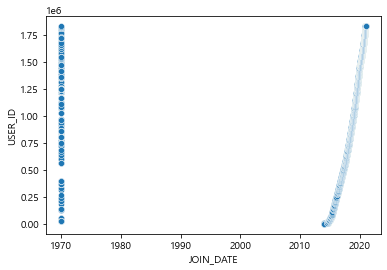

In [24]:
sns.scatterplot(data=df, x='JOIN_DATE', y = 'USER_ID')

### * D_TYPE 

* D_TYPE은 ID별 동일하여 USER별 바뀌지 않는 값. 가입 유저들을 구분하는 값으로 추정하였다. 

회사는 왜 D_TYPE을 나눴을까. D_TYPE별로 달라지는 특징은 무엇이 있을까. 

In [26]:
df.D_TYPE.unique()

array(['AA', 'BB', 'CC'], dtype=object)

In [27]:
df.groupby('USER_ID').D_TYPE.value_counts()

USER_ID  D_TYPE
224      AA         2
232      BB        23
342      AA         1
565      AA         2
729      AA         1
                   ..
1830551  BB         1
1830570  BB         1
1830580  AA         1
1830589  BB         1
1830598  AA         1
Name: D_TYPE, Length: 165425, dtype: int64

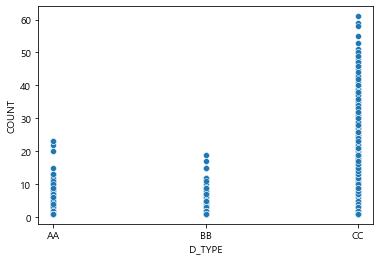

In [29]:
X = df["D_TYPE"] 
y = df["COUNT"] 
sns.scatterplot(x = X, y = y)
plt.show()

### * STORE_ID

* 중복 제거한 ID는 총 1061개 

In [30]:
len(df['STORE_ID'].unique())

1061

* STORE ID별 데이터 갯수(row count)

In [31]:
df['STORE_ID'].value_counts()

220557    17617
220893    17220
220655    16275
220848    15935
92437     15866
          ...  
181991        1
225653        1
67813         1
230216        1
230214        1
Name: STORE_ID, Length: 1061, dtype: int64

### * GOODS_TYPE

In [32]:
df.GOODS_TYPE.unique()

array(['A', 'C', 'B', 'D'], dtype=object)

* 가장 많이 이용된 상품 타입은 A > B > C > D 순서이다. 

In [33]:
df.GOODS_TYPE.value_counts()

A    609790
C    131163
B    118541
D     19777
Name: GOODS_TYPE, dtype: int64

* ID별 많이 이용하는 상품 타입

In [34]:
df[df['USER_ID']==999665].GOODS_TYPE.value_counts()

A    296
C     55
D     15
Name: GOODS_TYPE, dtype: int64

In [35]:
df[df['USER_ID']==1514190].GOODS_TYPE.value_counts()

A    61
B    29
C     3
Name: GOODS_TYPE, dtype: int64

* 1번만 서비스를 이용한 사람들이 사용한 상품 타입.  
A > B > C > D 순서이다 

In [36]:
df[df.groupby('USER_ID')['USER_ID'].transform('size') == 1].GOODS_TYPE.value_counts()

A    40387
C    17427
B    14275
D     2800
Name: GOODS_TYPE, dtype: int64

### * DATE

* 2020-01-01 ~ 2020-12-31 1년간 사용 데이터만 존재한다

In [37]:
df.DATE.sort_values()

0        2020-01-01
609      2020-01-01
610      2020-01-01
611      2020-01-01
612      2020-01-01
            ...    
877462   2020-12-31
877463   2020-12-31
877464   2020-12-31
877456   2020-12-31
879270   2020-12-31
Name: DATE, Length: 879271, dtype: datetime64[ns]

In [38]:
df['MONTH']=df['DATE'].dt.month
df['DAY']=df['DATE'].dt.dayofweek
df['WEEK']=df['DATE'].dt.week

<ipython-input-38-c541ea2d9f4b>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['WEEK']=df['DATE'].dt.week


In [40]:
# df['DATE'].dt.weekday()

* 평일/주말 비교

### * COUNT 

COUNT 는 1 ~ 61 번까지 있음

In [41]:
df.COUNT.value_counts(ascending=False)

# df.COUNT.value_counts().sort_values(ascending=True)

1     863775
2      13519
3       1061
4        271
5        136
6         66
7         45
9         25
12        21
16        21
8         20
13        19
14        19
15        19
28        17
10        16
11        15
17        15
23        15
25        14
21        14
18        14
19        13
22         9
26         9
32         9
34         7
24         7
27         7
30         7
31         7
29         6
20         6
36         5
40         4
35         3
37         3
38         3
39         3
49         3
46         3
33         2
47         2
42         2
43         2
50         2
58         1
53         1
55         1
59         1
45         1
51         1
48         1
44         1
41         1
61         1
Name: COUNT, dtype: int64

* COUNT의 갯수가 20번 이상인 경우는 대부분 ID 999665 이다. 

In [42]:
df[df['COUNT']> 20].USER_ID.value_counts()

999665     172
1467323      2
1635143      1
Name: USER_ID, dtype: int64

In [43]:
df[(df['COUNT'] > 20) & ((df['USER_ID']== 1467323) | (df['USER_ID']== 1635143)) ]

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,MONTH,DAY,WEEK
372116,1467323,2020-01-11,AA,220836,A,2020-06-27,22,JRR,6,5,26
419592,1467323,2020-01-11,AA,220836,B,2020-07-15,23,JRR,7,2,29
476895,1635143,2020-07-24,AA,221045,A,2020-08-04,23,GN,8,1,32


### * AD1 

In [44]:
df.AD1.unique()

array(['GN', 'J', 'SC', 'MP', 'JRR', 'YD', 'GJ', 'YO', 'GSN', 'GBC', 'BF',
       'DJ', '0', 'CD', 'NO', 'CY', 'YC', 'SD', 'GD', 'GSW', 'DM', 'R',
       'GB', 'GS', 'GHN', 'SB', 'IND', 'P', 'GW', 'JR', 'GEJ', 'GGY',
       'GKP', 'CAS', 'SG', 'BJG', 'BHW', 'GAY', 'GYI', 'CCA', 'PJP',
       'GGC', 'IYS', 'DB', 'GGM', 'GAS', 'WOID', 'DIV', 'AOI', 'COI',
       'GPJ', 'SOI', 'ABP', 'DOI', 'WF', 'BI', 'ZP', 'EP', 'Q', 'BO',
       'ZE', 'RRR', 'QGI', 'DSO', 'SOD', 'BOI', 'WT', 'BP', 'SP', 'CN',
       'SJV', 'SDU', 'QH', 'BUD', 'CU', 'VU', 'WAE', 'NW', 'DY', 'WH',
       'GR', 'X', 'CVB', 'ADS', 'VO'], dtype=object)

In [45]:
len(df['AD1'].unique())

85

* 지역명을 따온 것으로 유추됨.   
예. YO(여의도)

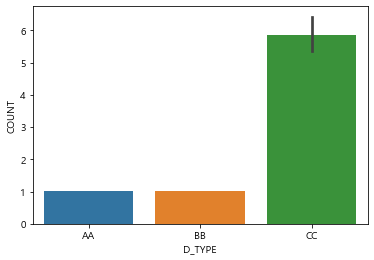

In [46]:
sns.barplot(x=X, y=y)
plt.title("")
plt.show()

In [48]:
# X = df["D_TYPE"] 
# y = df["GOODS_TYPE"] 
# sns.barplot(x=X, y=y)
# plt.title("")
# plt.show()

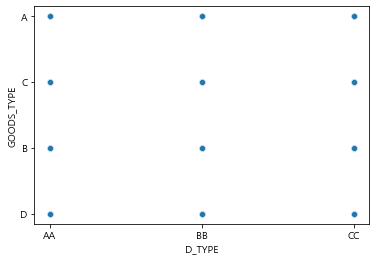

In [49]:
X = df["D_TYPE"] 
y = df["GOODS_TYPE"] 
sns.scatterplot(x = X, y = y)
plt.show()

<ipython-input-50-b478a9466679>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


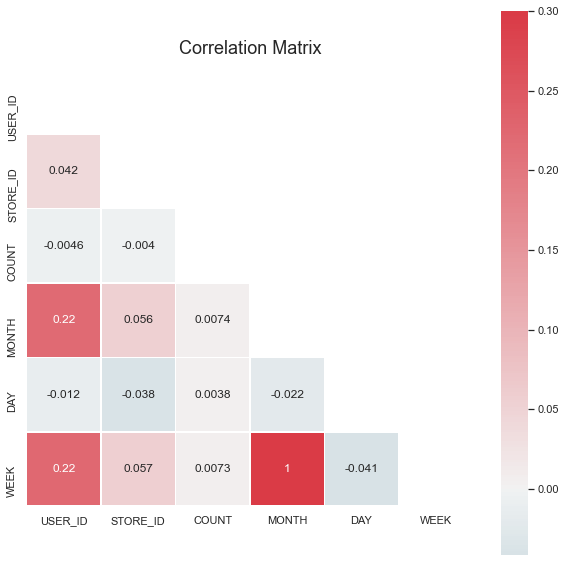

In [50]:
sns.set(style="white")
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlation Matrix', fontsize=18)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, annot=True)
plt.show()

* train, test set 생성

In [51]:
df_train = df[df['DATE']<'2020-10-01']
df_test=df[df['DATE']>='2020-10-01']

## ⚡ 3. 